In [5]:
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt

from multiple_shooting import setup_multiple_shooting
from cnlls_solver import solve_cnlls_ipopt, solve_cnlls_gauss_newton, solve_cnlls_gauss_newton_logparam
from utils import add_noise, evaluate_fit, print_formatted_params

In [6]:
from pyridine import make_pyridine_integrator, get_initial_state, get_true_parameters, simulate_pyridine_data

# ---------------------------------------------------
# Configuration Parameters
# ---------------------------------------------------
N = 12  # Number of multiple shooting intervals
nx = 7  # Number of state variables
np_p = 11  # Number of parameters to estimate
T = 6.0  # Total simulation time
k = 4  # Number of measurements in every interval

t_shooting = np.linspace(0, T, N + 1)  # Multiple shooting nodes (coarse)
t_meas = np.linspace(0, T, k * N + 1)  # Measurement nodes (finer)
dt = t_shooting[1] - t_shooting[0]

# ---------------------------------------------------
# Synthetic Measurement Generation
# ---------------------------------------------------
p_true = get_true_parameters()  # Ground-truth parameters
x0_true = get_initial_state()  # Initial state
y_meas = simulate_pyridine_data(x0_true, p_true, t_meas)  # True clean data
y_meas_noised = add_noise(y_meas, noise_level=0.01)  # Add synthetic noise (0 here)
y_meas_noised[0, 1:] = y_meas[0, 1:]  # Ensure initial condition of pyridine is accurate

# ---------------------------------------------------
# Multiple Shooting Setup
# ---------------------------------------------------
F = make_pyridine_integrator(dt)
w, X_end, F2, F3, S_vars, P_var = setup_multiple_shooting(
    integrator=F,
    t_shooting=t_shooting,
    nx=nx,
    np_p=np_p,
    enforce_state_nonneg=True,
    enforce_param_nonneg=True
)

# Residuals: Match each measurement time to corresponding shooting interval
F1 = []
meas_idx = 1
for i in range(N):
    t_interval_meas = [t for t in t_meas if t_shooting[i] < t <= t_shooting[i + 1]]
    xi = S_vars[i]
    for tm in t_interval_meas:
        dt_meas = tm - t_shooting[i]
        x_pred = make_pyridine_integrator(dt_meas)(x0=xi, p=P_var)['xf']
        F1.append(x_pred - y_meas_noised[meas_idx])
        meas_idx += 1

# Form residual vector: model prediction - noisy measurement
F1 = ca.vertcat(*F1)
p0 = np.ones(np_p)
w0 = np.concatenate([y_meas_noised[::k][:-1].reshape(-1), p0])  # Initial guess

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1397
Number of nonzeros in inequality constraint Jacobian.:       95
Number of nonzeros in Lagrangian Hessian.............:     1326

Total number of variables............................:       95
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       77
Total number of inequality constraints...............:       95
        inequality constraints with only lower bounds:       95
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  8.7841185e-01 2.75e-01 8.00e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

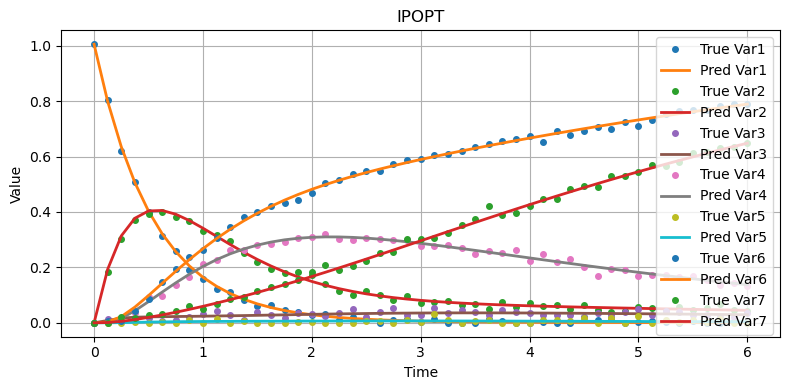


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.



CasADi - 2025-05-23 17:50:44 WARNING("F:step failed: NaN detected for output xf, at (row 1, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-05-23 17:50:44 WARNING("F:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-05-23 17:50:44 WARNING("F:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-05-23 17:50:44 WARNING("F:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-05-23 17:50:44 WARNING("F:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-05-23 17:50:44 WARNING("F:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-05-23 17:50:44 WARNING("F:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.c


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.



CasADi - 2025-05-23 17:50:44 WARNING("F:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-05-23 17:50:44 WARNING("F:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-05-23 17:50:44 WARNING("F:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-05-23 17:50:44 WARNING("F:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-05-23 17:50:44 WARNING("F:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-05-23 17:50:44 WARNING("F:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-05-23 17:50:44 WARNING("F:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.c


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.


qpOASES -- An Implementation of the Onl

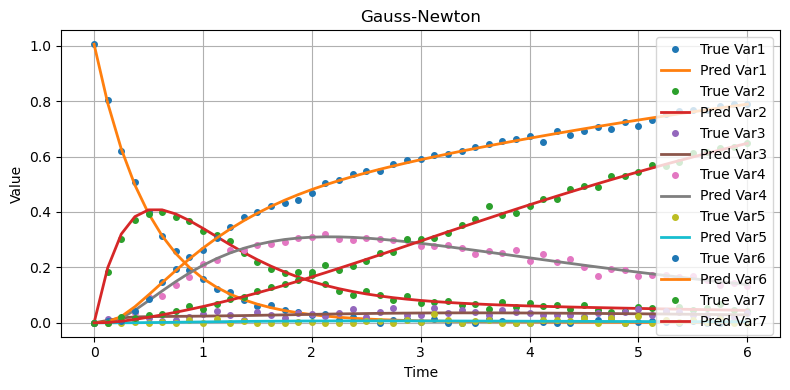

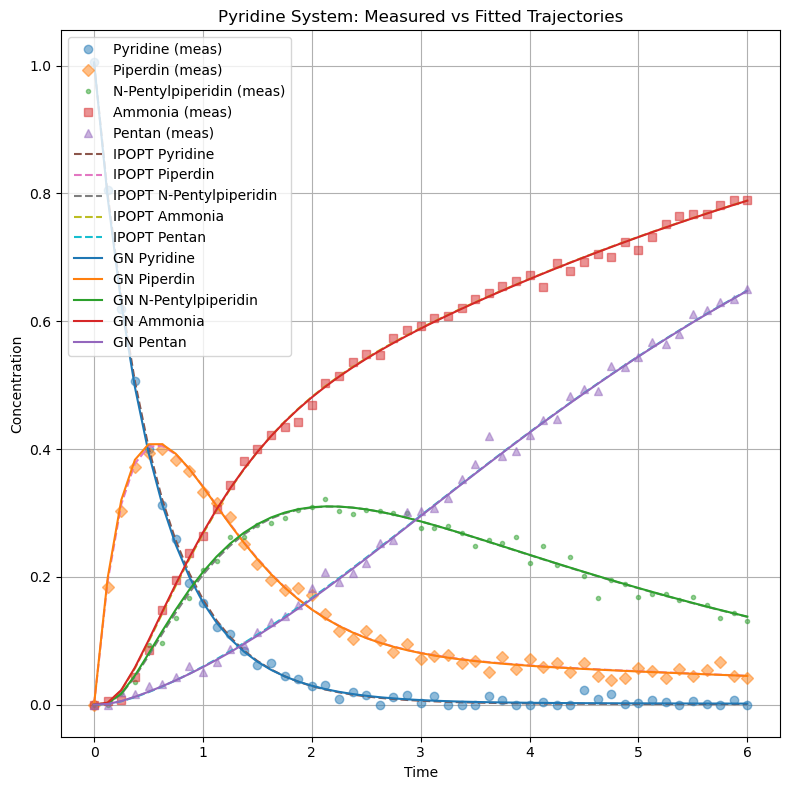

In [7]:
# ---------------------------------------------------
# Solve with IPOPT
# ---------------------------------------------------
sol_ipopt = solve_cnlls_ipopt(w=w, F1=F1, F2=F2, w0=w0, F3=F3)
w_opt_ipopt = sol_ipopt['x']
p_est_ipopt = w_opt_ipopt[-np_p:]
print_formatted_params(p_true, "True")
print_formatted_params(p_est_ipopt)

y_est_ipopt = simulate_pyridine_data(y_meas_noised[0], p_est_ipopt, t_meas)
evaluate_fit(y_meas_noised, y_est_ipopt, t_meas, label="IPOPT")

# ---------------------------------------------------
# Solve with Gauss-Newton (log-param)
# ---------------------------------------------------
sol_gn = solve_cnlls_gauss_newton_logparam(w=w, F1=F1, F2=F2, w0=w0)
w_opt_gn = sol_gn['x']
p_est_gn = w_opt_gn[-np_p:]
print_formatted_params(p_true, "True")
print_formatted_params(p_est_gn)

y_est_gn = simulate_pyridine_data(y_meas_noised[0], p_est_gn, t_meas)
evaluate_fit(y_meas_noised, y_est_gn, t_meas, label="Gauss-Newton")

# ---------------------------------------------------
# Visualization
# ---------------------------------------------------
plt.figure(figsize=(8, 8))

# Plot measured data
plt.plot(t_meas, y_meas_noised[:, 0], 'o', label='Pyridine (meas)', alpha=0.5)
plt.plot(t_meas, y_meas_noised[:, 1], 'D', label='Piperdin (meas)', alpha=0.5)
plt.plot(t_meas, y_meas_noised[:, 3], '.', label='N-Pentylpiperidin (meas)', alpha=0.5)
plt.plot(t_meas, y_meas_noised[:, 5], 's', label='Ammonia (meas)', alpha=0.5)
plt.plot(t_meas, y_meas_noised[:, 6], '^', label='Pentan (meas)', alpha=0.5)

# Plot IPOPT fitted trajectory
plt.plot(t_meas, y_est_ipopt[:, 0], '--', label='IPOPT Pyridine')
plt.plot(t_meas, y_est_ipopt[:, 1], '--', label='IPOPT Piperdin')
plt.plot(t_meas, y_est_ipopt[:, 3], '--', label='IPOPT N-Pentylpiperidin')
plt.plot(t_meas, y_est_ipopt[:, 5], '--', label='IPOPT Ammonia')
plt.plot(t_meas, y_est_ipopt[:, 6], '--', label='IPOPT Pentan')

# Plot GN fitted trajectory
plt.plot(t_meas, y_est_gn[:, 0], '-', label='GN Pyridine')
plt.plot(t_meas, y_est_gn[:, 1], '-', label='GN Piperdin')
plt.plot(t_meas, y_est_gn[:, 3], '-', label='GN N-Pentylpiperidin')
plt.plot(t_meas, y_est_gn[:, 5], '-', label='GN Ammonia')
plt.plot(t_meas, y_est_gn[:, 6], '-', label='GN Pentan')

# Plot formatting
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Pyridine System: Measured vs Fitted Trajectories')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
from notorious import get_initial_state, get_true_parameters, simulate_notorious_measurements, setup_notorious_shooting, notorious_simulate_with_integrator

# ---------------------------------------------------
# Configuration
# ---------------------------------------------------
mu = 1.0  # Fixed known parameter in dynamics
nx_not = 2  # State dimension
np_not = 1  # Number of parameters to estimate
t_meas_not = np.linspace(0, 1, 30)
N_not = len(t_meas_not) - 1

# ---------------------------------------------------
# Generate Noisy Measurements
# ---------------------------------------------------
p_true_not = get_true_parameters()  # True parameter value
x0_not = get_initial_state()  # Initial state
y_meas_not = simulate_notorious_measurements(mu, p_true_not, t_meas_not, noise_level=0.01)
y_meas_not[0, :] = [0.0, np.pi]  # Ensure initial condition is accurate

# ---------------------------------------------------
# Setup Direct Multiple Shooting Problem
# ---------------------------------------------------
w_not, X_end_not, F2_not, F3_not, S_vars_not, P_var_not = setup_notorious_shooting(
    t_grid=t_meas_not,
    nx=nx_not,
    np_p=np_not,
    mu=mu,
    enforce_param_nonneg=True
)

# Residual vector: model predictions - measurements
F1_not = ca.vertcat(*[X_end_not[i] - y_meas_not[i + 1] for i in range(N_not)])

# Initial guess: flattened measurement + rough p
w0_not = np.concatenate([y_meas_not[:-1].reshape(-1), [3.1]])

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      224
Number of nonzeros in inequality constraint Jacobian.:        1
Number of nonzeros in Lagrangian Hessian.............:      146

Total number of variables............................:       59
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       56
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.1380198e-02 3.94e-02 1.81e-02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

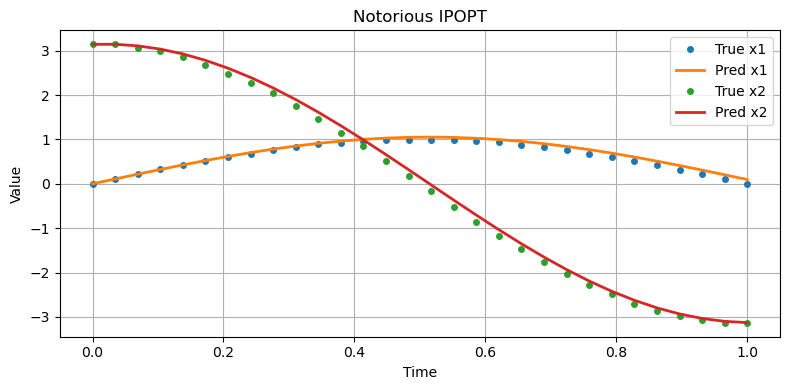

[Notorious GN] x1 Errors:
  RMSE = 0.1231
  MAE  = 0.0967
  R2   = 0.8547
[Notorious GN] x2 Errors:
  RMSE = 0.2492
  MAE  = 0.2263
  R2   = 0.9878


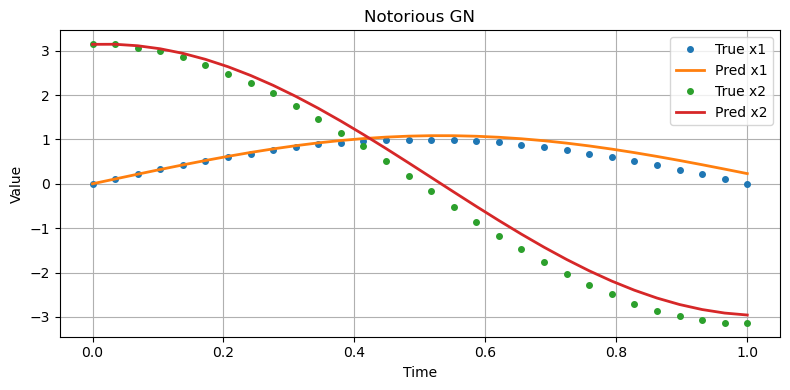

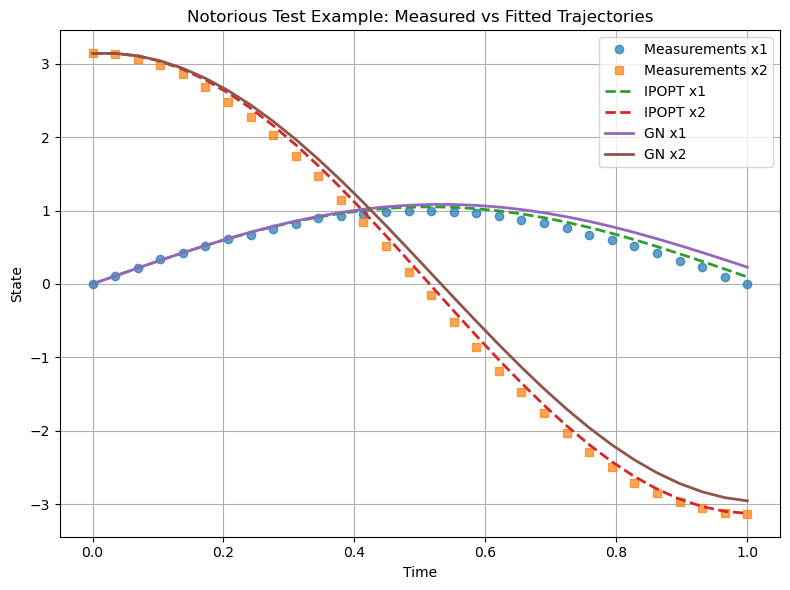

In [9]:
# ---------------------------------------------------
# Solve with IPOPT
# ---------------------------------------------------
sol_ipopt_not = solve_cnlls_ipopt(w=w_not, F1=F1_not, F2=F2_not, w0=w0_not, F3=F3_not)
w_opt_ipopt_not = sol_ipopt_not['x']
p_est_ipopt_not = w_opt_ipopt_not[-np_not:]
print("[Notorious][IPOPT] estimated parameter:", p_est_ipopt_not)

# ---------------------------------------------------
# Solve with Gauss-Newton (log-param)
# ---------------------------------------------------
sol_gn_not = solve_cnlls_gauss_newton_logparam(
    w=w_not, F1=F1_not, F2=F2_not, w0=w0_not, n_params=np_not
)
w_opt_gn_not = sol_gn_not['x']
p_est_gn_not = w_opt_gn_not[-np_not:]
print("[Notorious][GN] estimated parameter:", p_est_gn_not)

# ---------------------------------------------------
# Simulate Fitted Trajectories
# ---------------------------------------------------
y_est_ipopt_not = notorious_simulate_with_integrator(p_est_ipopt_not, mu, t_meas_not)
y_est_gn_not = notorious_simulate_with_integrator(p_est_gn_not, mu, t_meas_not)

# ---------------------------------------------------
# Evaluate Fit
# ---------------------------------------------------
evaluate_fit(y_meas_not, y_est_ipopt_not, t_meas_not, label="Notorious IPOPT", species_names=["x1", "x2"])
evaluate_fit(y_meas_not, y_est_gn_not, t_meas_not, label="Notorious GN", species_names=["x1", "x2"])

# ---------------------------------------------------
# Plot Results
# ---------------------------------------------------
plt.figure(figsize=(8, 6))
plt.plot(t_meas_not, y_meas_not[:, 0], 'o', label='Measurements x1', alpha=0.7)
plt.plot(t_meas_not, y_meas_not[:, 1], 's', label='Measurements x2', alpha=0.7)
plt.plot(t_meas_not, y_est_ipopt_not[:, 0], '--', label='IPOPT x1', linewidth=2)
plt.plot(t_meas_not, y_est_ipopt_not[:, 1], '--', label='IPOPT x2', linewidth=2)
plt.plot(t_meas_not, y_est_gn_not[:, 0], '-', label='GN x1', linewidth=2)
plt.plot(t_meas_not, y_est_gn_not[:, 1], '-', label='GN x2', linewidth=2)
plt.xlabel('Time')
plt.ylabel('State')
plt.title('Notorious Test Example: Measured vs Fitted Trajectories')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()